# Tutorial 2: scattering transform

Authors: René Steinmann and Léonard Seydoux

Date: January 16, 2023

Welcome to this tutorial on transforming seismic data into scattering coefficients using a scattering network. In this Jupyter notebook, we will walk through the process of using the scattering network to extract useful features from seismic data. This technique has been proven to be efficient for clustering various types of seismic signals from continuous seismic data. We will begin by introducing the basic concepts of scattering networks and then move on to implementing the technique using Python and the ScatSeisNet library.

In [1]:
import numpy as np
import obspy 
import os
import pickle
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime

from matplotlib import dates as mdates
from matplotlib import pyplot as plt

## Paths

Please, ensure that you have read and write permission in the following path. Also make sure that the path is located outside the repository, or that is is correctly ignored in the `.gitignore` file, to prevent from pushing it or erasing it when pulling from the main branch.

In [2]:
SAVE_PATH = "example/"

## Load seismic data

This case serves as a basic example of how the scattering network can be applied to various data sets. The example data used in this case is a small subset of the data from the [IRIS data center](https://ds.iris.edu/ds/nodes/dmc/), specifically two hours of three-component data from our study Steinmann et al. ([2021](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JB022455)). Note that this can be easily adapted to handle larger and more complex data sets by simply adjusting the input parameters and increasing the computational resources.

In [3]:
# Connect to the IRIS datacenter
client = Client("IRIS")

# Collect waveforms from the datacenter
stream = client.get_waveforms(
    network="YH",
    station="DC06",
    location="*",
    channel="*",
    starttime=UTCDateTime("2012-07-25T00:00"),
    endtime=UTCDateTime("2012-07-25T02:00"),
)

## Waveform pre-processing

It may often be useful to remove the trend, merge potentially non-overlapping segments, etc. For finding the best processing strategy, depending on the data at hand, we suggest to have a look at the different [signal processing routines for ObsPy](https://docs.obspy.org/packages/obspy.signal.html).

In the following cell, we merge together the potentially non-overlapping data segments, detrend the resulting trace and high-pass filter it above 1 Hz.

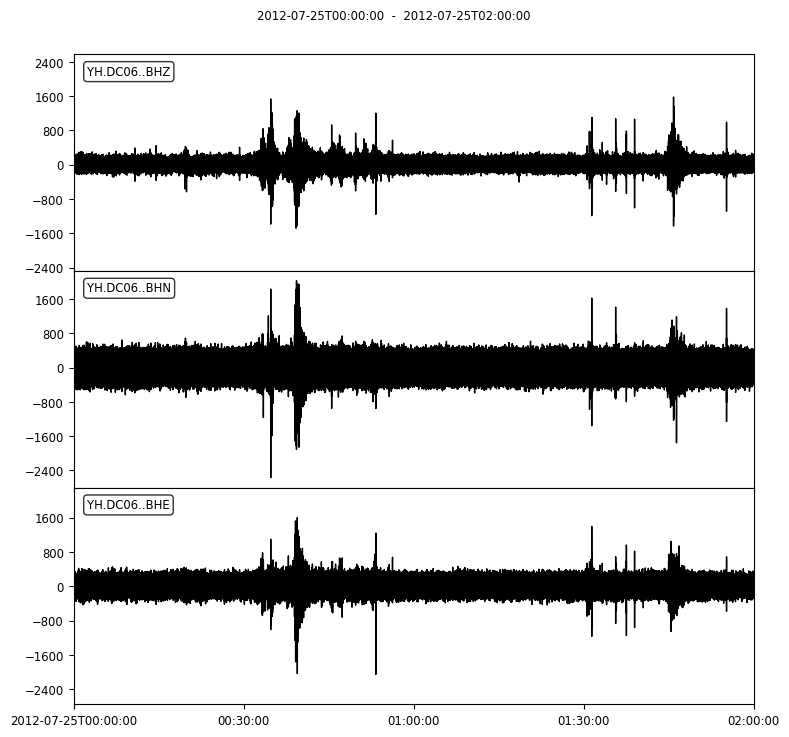

In [4]:
stream.merge(method=1)
stream.detrend("linear")
stream.filter(type="highpass", freq=1.0)
stream.plot();

## Segment extraction

This stage allow to chunk the data into equal-length segments with a duration defined in the tutorial 1 notebook. For this we need to load the scattering network previously defined, so we make sure that the data segmentation corresponds to the loaded network.

In [5]:
# Load the scattering network
filepath = os.path.join(SAVE_PATH, "scattering_network.pickle")
network = pickle.load(open(filepath, "rb"))

# Extract segment length (from any layer)
segment_duration = network.banks[0].bins / network.banks[0].sampling_rate
overlap = 0.5

Now we chunk the data with the `stream.slide` method. Note that for larger datasets, this should be adapted since this method is not optimal.

In [6]:
# Gather list for timestamps and segments
timestamps = list()
segments = list()

# Loop over the entire stream
for traces in stream.slide(segment_duration, segment_duration * overlap):

    # Turn into a numpy array, and discard extra sample
    segment = np.array([trace.data for trace in traces])
    segment = segment[:, :-1]

    # Collect first timestamp and data segment
    timestamps.append(traces[0].times("matplotlib")[0])
    segments.append(segment)

## Scattering transformation

After collecting the data segments and the scattering network, we can now caclulate the scattering coefficients. Here we also set what kind of pooling we want to use by setting the `reduce_type` keyword argument to maximum (`max`) or average pooling (`avg`). 

In [7]:
scattering_coefficients = network.transform(segments, reduce_type="max")

In the following example one can observe the scattering coefficients.

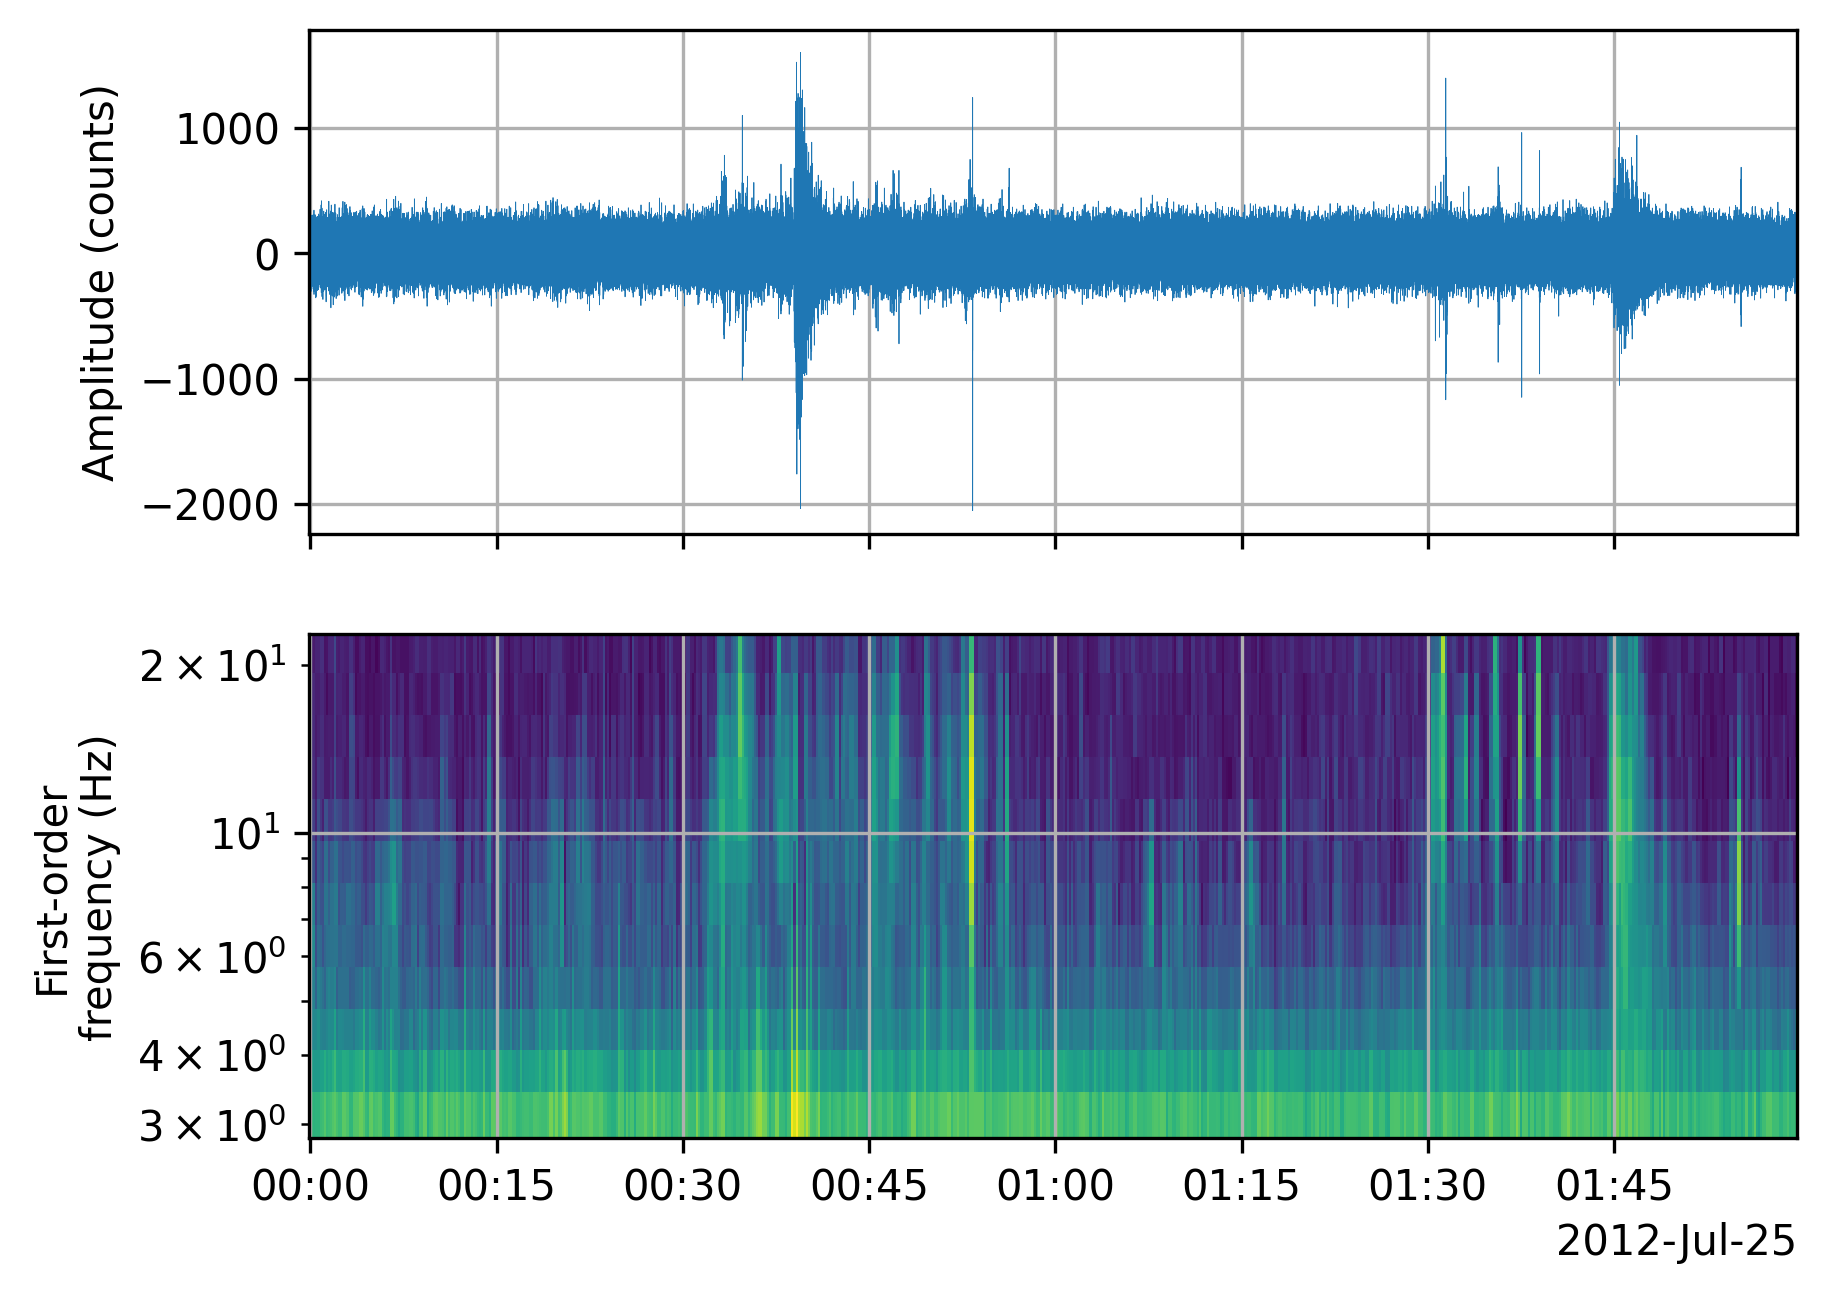

In [8]:
CHANNEL = 0

# Create figure and axes
fig, ax = plt.subplots(2, sharex=True, dpi=300)

# Extract display information
frequencies = network.banks[0].centers

# Extract first-order scattering coefficients for a given channel.
# The shape is (n_segments, n_channels, n_features).
order_1 = scattering_coefficients[0]
order_1 = np.squeeze(order_1[:, CHANNEL, :])

# Take the log (like for power spectrum)
order_1 = np.log(order_1)

# Plot the waveform
ax[0].plot(stream[CHANNEL].times("matplotlib"), stream[CHANNEL].data, rasterized=True, lw=0.2)

ax[1].pcolormesh(
    timestamps,
    frequencies,
    order_1.T,
    rasterized=True,
)

# Labels and cosmetics
ax[0].set_ylabel("Amplitude (counts)")
ax[0].grid()
ax[1].set_yscale("log")
ax[1].set_ylabel("First-order\nfrequency (Hz)")
dateticks = mdates.AutoDateLocator()
ax[1].xaxis.set_major_locator(dateticks)
ax[1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(dateticks))
ax[1].grid()

## Save the output

Until now, we applied the scattering network to the three-component seismic data. In the next tutorial, we use the FastICA to extract the most relevant features from the scattering coefficients. Therefore, we save the first and second-order scattering coefficients as a npz-file.

In [9]:
filepath = os.path.join(SAVE_PATH, "scattering_coefficients.npz")
np.savez(
    filepath,
    order_1=scattering_coefficients[0],
    order_2=scattering_coefficients[1],
    times=timestamps,
)